In [27]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from engine import Value
from trace_graph import draw_dot
from neural_network import MultiLayerPerceptron

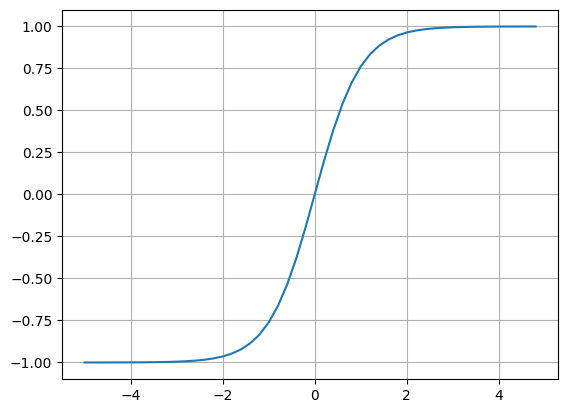

In [28]:
# the tanh function
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid();

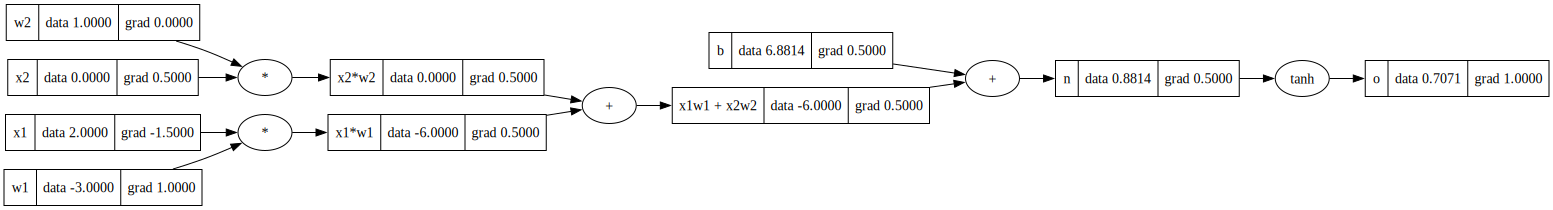

In [29]:
# inputs x1, x2 of 2D nueron
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias b of the nueron
b = Value(6.88137358, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1 * w1; x1w1.label = 'x1*w1'
x2w2 = x2 * w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = "x1w1 + x2w2"
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

o.backward()

draw_dot(o)

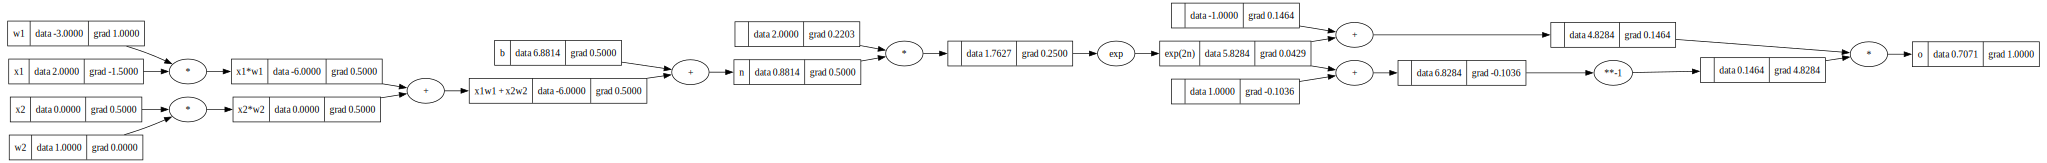

In [30]:
# inputs x1, x2 of 2D nueron
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias b of the nueron
b = Value(6.88137358, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1 * w1; x1w1.label = 'x1*w1'
x2w2 = x2 * w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = "x1w1 + x2w2"
n = x1w1x2w2 + b; n.label = 'n'
# --- now break down tanh(), expect same forward pass and backward, aka same values and gradients as when used tanh()
e = (2*n).exp()
e.label = 'exp(2n)'
o = (e - 1) / (e + 1)
o.label = 'o'
# ---
o.backward()

draw_dot(o)

In [31]:
"""
micrograd is roughly modeled after PyTorch
micrograd is a scalar valued engine, scalar values like 2.0

pytorch is modeled on tensors
"""
import torch

# note: tensor default type is float32, here we cast to doubles for a single precision float
# note: pytorch assumes by default that leaf nodes do not require gradients, this is for efficiency reasons, so we will set this to True explicitly
x1 = torch.Tensor([2.0]).double(); x1.requires_grad = True
x2 = torch.Tensor([0.0]).double(); x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double(); w1.requires_grad = True
w2 = torch.Tensor([1.0]).double(); w2.requires_grad = True
b = torch.Tensor([6.88137358]).double(); b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)  # this is a tensor, with a data and grad attributes

# we call .item(), takes tensor of single item and strips the tensor
# o.item() and o.data.item() produce the same result in PyTorch
# o is a tensor object which also has a backward function
print(o.data.item())  
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [ ]:
x = [2.0, 3.0, -1.0]  # 3 dimensional input
n = MultiLayerPerceptron(3, [4, 4, 1])  # 3 input and 2 layers of 4 and 1 output layer
print(n(x))
#draw_dot(n(x))
print(len(n.parameters()))

Value(data=-0.985270763199166,grad=0.0)
41
[Value(data=-0.26537900559214567,grad=0.0), Value(data=-0.8844752233425563,grad=0.0), Value(data=0.8980060914709529,grad=0.0), Value(data=-0.9006374719715975,grad=0.0), Value(data=-0.4592255386015809,grad=0.0), Value(data=0.8660912418179441,grad=0.0), Value(data=-0.5415776817140519,grad=0.0), Value(data=-0.8109286471913872,grad=0.0), Value(data=-0.43299844462698145,grad=0.0), Value(data=-0.04019960820212076,grad=0.0), Value(data=0.5263167100113244,grad=0.0), Value(data=-0.4304492972019689,grad=0.0), Value(data=0.3885280983713295,grad=0.0), Value(data=0.21810885844415218,grad=0.0), Value(data=0.4499198218449514,grad=0.0), Value(data=0.006819034172200755,grad=0.0), Value(data=0.42934121469790054,grad=0.0), Value(data=0.8649880936279133,grad=0.0), Value(data=-0.45513715910375985,grad=0.0), Value(data=0.10860792357155535,grad=0.0), Value(data=-0.8072861743101409,grad=0.0), Value(data=-0.943741287719859,grad=0.0), Value(data=0.10448542500401303,gra

In [ ]:
n.parameters()  # all the weights and biases in the neural net, this has 41 of these parameters

[Value(data=-0.7980076740514226,grad=0.0),
 Value(data=0.8143633517877131,grad=0.0),
 Value(data=0.3119366537349686,grad=0.0),
 Value(data=0.6747271360634757,grad=0.0),
 Value(data=0.014015850818070552,grad=0.0),
 Value(data=0.8317101669599536,grad=0.0),
 Value(data=-0.06201064708170412,grad=0.0),
 Value(data=-0.32690640954172423,grad=0.0),
 Value(data=0.5735446342579251,grad=0.0),
 Value(data=0.8444224656117147,grad=0.0),
 Value(data=0.5527315039821925,grad=0.0),
 Value(data=-0.9366412695094899,grad=0.0),
 Value(data=-0.0030899800026429336,grad=0.0),
 Value(data=0.5609247661544132,grad=0.0),
 Value(data=0.6476043414422905,grad=0.0),
 Value(data=-0.32167774459891896,grad=0.0),
 Value(data=-0.32781306441330393,grad=0.0),
 Value(data=0.38924888638384525,grad=0.0),
 Value(data=0.1311742721256215,grad=0.0),
 Value(data=-0.23623847965639544,grad=0.0),
 Value(data=0.443761193230352,grad=0.0),
 Value(data=0.21337439509751177,grad=0.0),
 Value(data=-0.46886110647892765,grad=0.0),
 Value(data=0

In [35]:
# simple example dataset
# xs has 4 examples, aka 4 possible inputs into the neural net
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]
# this will be a simple binary classifier neural network
# first xs example [2.0, 3.0, -1.0] should result in 1.0, etc
ys = [1.0, -1.0, -1.0, 1.0]  # desired targets

In [48]:
# Step 1: Forward pass
ypred = [n(x) for x in xs]
print("ypred", ypred)  # this is the prediction given the 4 examples
# how do you tune the weights to better predict the desired targets?

# Calculate the loss
# we will use a single number to calculate the total performance of your neural net...this is the loss
# let's look at the mean squared error loss
# ygt = y ground truth
# we want to minimize the loss, this means that every target is close to prediction
# aka low loss means the predictions are matching the targets better
# the loss values are 0 only when yout is equal to y ground truth
losses = [(yout - ygt) ** 2 for ygt, yout in zip(ys, ypred)]
loss = sum(losses)
print("loss", loss)

# this will have 4 forward passes of the neural net, and the loss on top, with the loss value at the very right
# xs are inputs to the neural net
# gradient values on input data are not that useful to us because the input data is not changeable, aka they are fixed inputs
# the weight and bias for each neuron in the neural net we do want to change, the gradients of those matter

# draw_dot(loss)

ypred [Value(data=-0.9821361376439306,grad=0.0), Value(data=-0.9410715773000979,grad=0.0), Value(data=-0.9274328054405857,grad=0.0), Value(data=-0.968763401749724,grad=0.0)]
loss Value(data=7.813631556951266,grad=0.0)


In [49]:
# Step 2: Backward Pass
loss.backward()

In [50]:
# Step 3: Update - aka nudge
# we want to minimize the loss, aka decrease it
# the learning rate 0.01 here can be tricky, too low and it takes way too long to converge, too high and your loss may explode
# finding the step size to be just right is an art with vanilla gradient descent
for p in n.parameters():
    p.data += -0.01 * p.grad

In [51]:
# do this on a loop, this is gradient descent
ypred

[Value(data=-0.9821361376439306,grad=-3.964272275287861),
 Value(data=-0.9410715773000979,grad=0.11785684539980412),
 Value(data=-0.9274328054405857,grad=0.1451343891188286),
 Value(data=-0.968763401749724,grad=-3.937526803499448)]

In [52]:
# these are the weights and biases that makes our network preduct the desired targets very very close
n.parameters()

[Value(data=-0.26723876909972016,grad=0.07735951111965017),
 Value(data=-0.8843178222157737,grad=-0.006468543517534445),
 Value(data=0.8971873687788763,grad=0.034060234323237945),
 Value(data=-0.9016076264843679,grad=0.040403151908016896),
 Value(data=-0.46418000424675543,grad=0.20109340432031989),
 Value(data=0.8603588400055642,grad=0.23344020380555167),
 Value(data=-0.5375940318297429,grad=-0.16064546146401648),
 Value(data=-0.8153010951984317,grad=0.17697009470425093),
 Value(data=-0.42964990394659786,grad=-0.1378091999112542),
 Value(data=-0.03613978108162739,grad=-0.16729003498316172),
 Value(data=0.5220560965177237,grad=0.1759249499145095),
 Value(data=-0.4281728030194041,grad=-0.09325598313459332),
 Value(data=0.3856611898376547,grad=0.11838641959340374),
 Value(data=0.21527055602913767,grad=0.11742868191966765),
 Value(data=0.4527161577315826,grad=-0.11524944474131667),
 Value(data=0.004022790950586631,grad=0.1152011784978265),
 Value(data=0.44758908250634993,grad=-0.7499523894

In [53]:
# init neural net
n = MultiLayerPerceptron(3, [4, 4, 1])  # 3 input and 2 layers of 4 and 1 output layer

# here's the data
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0]  # desired targets

In [54]:
# let's put it all together - gradient descent

for k in range(20):

    # forward pass
    ypred = [n(x) for x in xs]
    # evaluate the loss
    loss = sum([(yout - ygt) ** 2 for ygt, yout in zip(ys, ypred)])
    # backward pass - don't forget to zero out the gradients of the parameters!!!
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()
    # update - simple stochastic gradient update
    for p in n.parameters():
        p.data += -0.05 * p.grad
    
    print(k, loss.data, )


0 4.3194986102742385
1 1.978594232051802
2 0.8064111492690594
3 0.4215335089410699
4 0.2824822891687584
5 0.22736728408284143
6 0.1894280331068931
7 0.1614607007833492
8 0.14004988370550409
9 0.12318928956063253
10 0.10960913087040686
11 0.09846632358887851
12 0.0891799573209765
13 0.08133740623958136
14 0.07463797000806681
15 0.06885764911888714
16 0.06382637206722738
17 0.05941283924866513
18 0.05551417798063009
19 0.052048722658264795


In [55]:
ypred

[Value(data=0.8881043088337081,grad=-0.2237913823325839),
 Value(data=-0.892026495179349,grad=0.2159470096413021),
 Value(data=-0.8691879619838525,grad=0.261624076032295),
 Value(data=0.8962791731449781,grad=-0.20744165371004386)]

In [26]:
# neural nets are mathematical expressions that take inputs as data and inputs as weights
# the loss function measures the accuracy of predictions
# low loss means the network is doing what you want it to do
# then we do backprogation to get the gradients so we know how to tune the weights
# we follow the gradient information that minimizes the loss